In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anksin88","key":"3648c618334f629235908b21668740fb"}'}

In [ ]:
#Create Kaggle directory to store the key
!mkdir ~/.kaggle
!cp "kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#Download data set from Kaggle
!kaggle competitions download -c aptos2019-blindness-detection

100% 9.51G/9.51G [07:17<00:00, 23.4MB/s]
100% 9.51G/9.51G [07:17<00:00, 23.4MB/s]


In [ ]:
#Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Create a folder and extract the downloaded zip dataset
!mkdir -p "/content/drive/My Drive/AA2_Project_APTOS2019/"

In [ ]:
import zipfile
import os

# Set the path in Google Drive
dataset_path = "/content/drive/My Drive/AA2_Project_APTOS2019/"

# Create the directory if not exists
os.makedirs(dataset_path, exist_ok=True)

# Extract dataset to Google Drive
with zipfile.ZipFile("aptos2019-blindness-detection.zip", 'r') as zip_ref:
    zip_ref.extractall(dataset_path)

print("Dataset extracted to:", dataset_path)

Dataset extracted to: /content/drive/My Drive/AA2_Project_APTOS2019/


In [ ]:
# Set paths for the CSV files
train_csv_path = "/content/drive/MyDrive/AA2_Project_APTOS2019/train.csv"

# Set path for images
train_images_path = "/content/drive/MyDrive/AA2_Project_APTOS2019/train_images/"

In [ ]:
!pip install torch torchvision pandas numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

In [ ]:
# Load CSV file
train_df = pd.read_csv(train_csv_path)
print(train_df.head())  # Show first few rows

        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0


In [ ]:
# Split train data into train and validation sets
train_ratio = 0.8  # 80% for training, 20% for validation
train_size = int(train_ratio * len(train_df))
val_size = len(train_df) - train_size
train_indices, val_indices = random_split(range(len(train_df)), [train_size, val_size])

# Convert indices to DataFrame slices
train_df_split = train_df.iloc[list(train_indices)].reset_index(drop=True)
val_df_split = train_df.iloc[list(val_indices)].reset_index(drop=True)

# Define dataset class
default_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class EyeDataset(Dataset):
    def __init__(self, dataframe, image_path, transform=default_transform):
        self.df = dataframe
        self.image_path = image_path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0] + ".png"
        img_path = os.path.join(self.image_path, img_name)
        image = Image.open(img_path).convert('RGB')
        label = int(self.df.iloc[idx, 1])  # Ensure label is integer
        if self.transform:
            image = self.transform(image)
        return image, label

# Create data loaders
batch_size = 32
train_dataset = EyeDataset(train_df_split, train_images_path)
val_dataset = EyeDataset(val_df_split, train_images_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Train function
def train_model(model, train_loader, val_loader, epochs=5):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model.train()

    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        train_acc = correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}")
    return model


In [ ]:
# Load pretrained models RESNET18
resnet_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 5)

In [ ]:
# Load pretrained models RESNET50
resnet_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 5)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 121MB/s]


In [ ]:
# Load pretrained models ViT
vit_model = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
vit_model.heads.head = nn.Linear(vit_model.heads.head.in_features, 5)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 132MB/s]


In [ ]:
# Load pretrained models EFFICIENTNET
efficientnet_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
efficientnet_model.classifier[1] = nn.Linear(efficientnet_model.classifier[1].in_features, 5)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 139MB/s]


In [ ]:
# Evaluate function
def evaluate_model(model, val_loader):
    model.eval()
    model = model.to(device)
    correct, total = 0, 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    print(f'Validation Accuracy: {100 * correct / total:.2f}%')

    # Compute confusion matrix and classification report
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds)

    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", cr)

    # Plot confusion matrix
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
# Train and evaluate models
print("Training ResNet18...")
resnet_model = train_model(resnet_model, train_loader, val_loader)
evaluate_model(resnet_model, val_loader)

Training ResNet...


100%|██████████| 92/92 [55:11<00:00, 36.00s/it]


Epoch [1/5], Loss: 0.7487, Train Acc: 0.7166


100%|██████████| 92/92 [06:52<00:00,  4.48s/it]


Epoch [2/5], Loss: 0.5899, Train Acc: 0.7794


100%|██████████| 92/92 [06:49<00:00,  4.46s/it]


Epoch [3/5], Loss: 0.5440, Train Acc: 0.7842


100%|██████████| 92/92 [06:49<00:00,  4.45s/it]


Epoch [4/5], Loss: 0.4780, Train Acc: 0.8170


100%|██████████| 92/92 [06:50<00:00,  4.46s/it]


Epoch [5/5], Loss: 0.4143, Train Acc: 0.8406
Validation Accuracy: 63.85%


Training ResNet-50...


100%|██████████| 92/92 [07:00<00:00,  4.57s/it]


Epoch [1/12], Loss: 0.6982, Train Acc: 0.7484


100%|██████████| 92/92 [06:56<00:00,  4.53s/it]


Epoch [2/12], Loss: 0.5347, Train Acc: 0.7948


100%|██████████| 92/92 [06:58<00:00,  4.55s/it]


Epoch [3/12], Loss: 0.4478, Train Acc: 0.8214


100%|██████████| 92/92 [06:57<00:00,  4.54s/it]


Epoch [4/12], Loss: 0.3869, Train Acc: 0.8511


100%|██████████| 92/92 [06:58<00:00,  4.54s/it]


Epoch [5/12], Loss: 0.3700, Train Acc: 0.8696


100%|██████████| 92/92 [06:57<00:00,  4.54s/it]


Epoch [6/12], Loss: 0.3263, Train Acc: 0.8778


100%|██████████| 92/92 [06:57<00:00,  4.53s/it]


Epoch [7/12], Loss: 0.2551, Train Acc: 0.9092


100%|██████████| 92/92 [06:58<00:00,  4.55s/it]


Epoch [8/12], Loss: 0.2236, Train Acc: 0.9112


100%|██████████| 92/92 [06:55<00:00,  4.52s/it]


Epoch [9/12], Loss: 0.1804, Train Acc: 0.9338


100%|██████████| 92/92 [06:59<00:00,  4.56s/it]


Epoch [10/12], Loss: 0.1241, Train Acc: 0.9587


100%|██████████| 92/92 [06:58<00:00,  4.55s/it]


Epoch [11/12], Loss: 0.1381, Train Acc: 0.9512


100%|██████████| 92/92 [06:54<00:00,  4.50s/it]


Epoch [12/12], Loss: 0.1236, Train Acc: 0.9638
Validation Accuracy: 82.13%
Confusion Matrix:
 [[365  11   2   0   0]
 [  4  53  15   0   0]
 [  0  23 135  10  10]
 [  0   2  17  16   3]
 [  0   2  22  10  33]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       378
           1       0.58      0.74      0.65        72
           2       0.71      0.76      0.73       178
           3       0.44      0.42      0.43        38
           4       0.72      0.49      0.58        67

    accuracy                           0.82       733
   macro avg       0.69      0.67      0.68       733
weighted avg       0.83      0.82      0.82       733



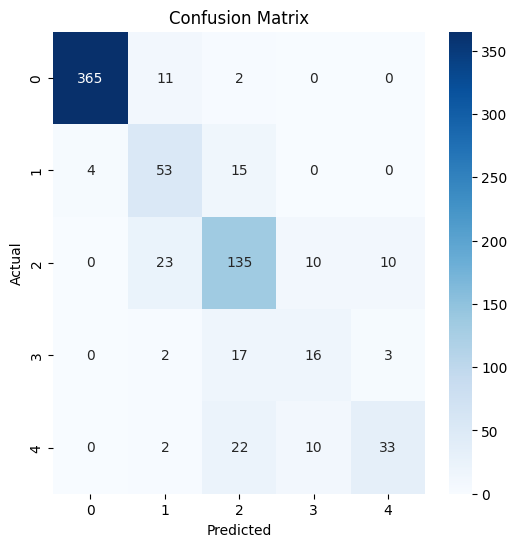

In [ ]:
print("Training ResNet-50...")
resnet_model = train_model(resnet_model, train_loader, val_loader, epochs=12)
evaluate_model(resnet_model, val_loader)

In [ ]:
print("Training ViT...")
vit_model = train_model(vit_model, train_loader, val_loader, epochs=20)
evaluate_model(vit_model, val_loader)

Training ViT...


100%|██████████| 92/92 [08:27<00:00,  5.51s/it]


Epoch [1/20], Loss: 1.4189, Train Acc: 0.4449


100%|██████████| 92/92 [08:11<00:00,  5.34s/it]


Epoch [2/20], Loss: 1.2091, Train Acc: 0.5490


100%|██████████| 92/92 [08:09<00:00,  5.32s/it]


Epoch [3/20], Loss: 1.1298, Train Acc: 0.5801


100%|██████████| 92/92 [08:11<00:00,  5.34s/it]


Epoch [4/20], Loss: 1.0094, Train Acc: 0.6320


100%|██████████| 92/92 [08:10<00:00,  5.34s/it]


Epoch [5/20], Loss: 0.9222, Train Acc: 0.6668


100%|██████████| 92/92 [08:07<00:00,  5.30s/it]


Epoch [6/20], Loss: 0.9094, Train Acc: 0.6705


100%|██████████| 92/92 [08:09<00:00,  5.32s/it]


Epoch [7/20], Loss: 0.8650, Train Acc: 0.6873


100%|██████████| 92/92 [08:08<00:00,  5.31s/it]


Epoch [8/20], Loss: 0.8567, Train Acc: 0.6832


100%|██████████| 92/92 [08:07<00:00,  5.30s/it]


Epoch [9/20], Loss: 0.8486, Train Acc: 0.6948


100%|██████████| 92/92 [08:06<00:00,  5.29s/it]


Epoch [10/20], Loss: 0.8222, Train Acc: 0.6972


100%|██████████| 92/92 [08:07<00:00,  5.30s/it]


Epoch [11/20], Loss: 0.8212, Train Acc: 0.6975


100%|██████████| 92/92 [08:08<00:00,  5.31s/it]


Epoch [12/20], Loss: 0.8001, Train Acc: 0.7084


100%|██████████| 92/92 [08:09<00:00,  5.32s/it]


Epoch [13/20], Loss: 0.8887, Train Acc: 0.6794


100%|██████████| 92/92 [08:09<00:00,  5.32s/it]


Epoch [14/20], Loss: 0.8429, Train Acc: 0.6927


100%|██████████| 92/92 [08:10<00:00,  5.33s/it]


Epoch [15/20], Loss: 0.8170, Train Acc: 0.6955


100%|██████████| 92/92 [08:08<00:00,  5.31s/it]


Epoch [16/20], Loss: 0.7920, Train Acc: 0.7064


100%|██████████| 92/92 [08:08<00:00,  5.31s/it]


Epoch [17/20], Loss: 0.7734, Train Acc: 0.7156


100%|██████████| 92/92 [08:06<00:00,  5.29s/it]


Epoch [18/20], Loss: 0.7635, Train Acc: 0.7180


100%|██████████| 92/92 [08:08<00:00,  5.30s/it]


Epoch [19/20], Loss: 0.8011, Train Acc: 0.7095


100%|██████████| 92/92 [08:09<00:00,  5.32s/it]

Epoch [20/20], Loss: 0.8176, Train Acc: 0.7019


NameError: name 'evaluate_model' is not defined

Validation Accuracy: 73.26%
Confusion Matrix:
 [[358   8  20   0   0]
 [  8  29  34   0   0]
 [ 17  23 150   0   0]
 [  3   3  38   0   0]
 [  2   5  35   0   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.93       386
           1       0.43      0.41      0.42        71
           2       0.54      0.79      0.64       190
           3       0.00      0.00      0.00        44
           4       0.00      0.00      0.00        42

    accuracy                           0.73       733
   macro avg       0.38      0.43      0.40       733
weighted avg       0.67      0.73      0.69       733



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


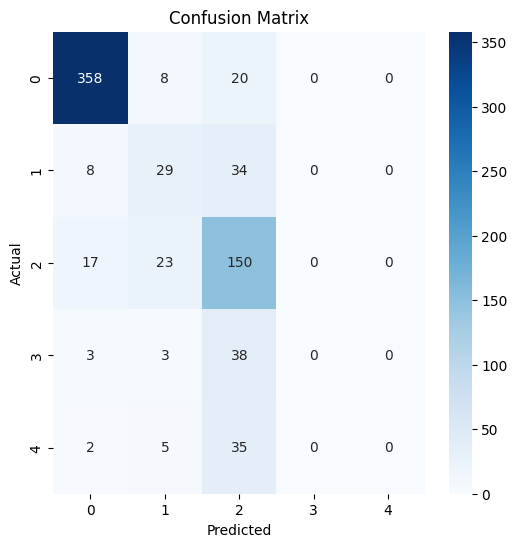

In [ ]:
evaluate_model(vit_model, val_loader)

Training EfficientNet...


100%|██████████| 92/92 [06:43<00:00,  4.38s/it]


Epoch [1/12], Loss: 0.6825, Train Acc: 0.7569


100%|██████████| 92/92 [06:42<00:00,  4.37s/it]


Epoch [2/12], Loss: 0.5116, Train Acc: 0.8112


100%|██████████| 92/92 [06:38<00:00,  4.34s/it]


Epoch [3/12], Loss: 0.4121, Train Acc: 0.8426


100%|██████████| 92/92 [06:38<00:00,  4.33s/it]


Epoch [4/12], Loss: 0.3880, Train Acc: 0.8529


100%|██████████| 92/92 [06:37<00:00,  4.32s/it]


Epoch [5/12], Loss: 0.3143, Train Acc: 0.8846


100%|██████████| 92/92 [06:37<00:00,  4.32s/it]


Epoch [6/12], Loss: 0.2553, Train Acc: 0.9075


100%|██████████| 92/92 [06:37<00:00,  4.32s/it]


Epoch [7/12], Loss: 0.2206, Train Acc: 0.9228


100%|██████████| 92/92 [06:38<00:00,  4.33s/it]


Epoch [8/12], Loss: 0.1924, Train Acc: 0.9321


100%|██████████| 92/92 [06:35<00:00,  4.30s/it]


Epoch [9/12], Loss: 0.1566, Train Acc: 0.9437


100%|██████████| 92/92 [06:36<00:00,  4.31s/it]


Epoch [10/12], Loss: 0.1391, Train Acc: 0.9525


100%|██████████| 92/92 [06:36<00:00,  4.31s/it]


Epoch [11/12], Loss: 0.1246, Train Acc: 0.9601


100%|██████████| 92/92 [06:36<00:00,  4.31s/it]


Epoch [12/12], Loss: 0.0981, Train Acc: 0.9665
Validation Accuracy: 81.72%
Confusion Matrix:
 [[368   9   1   0   0]
 [ 12  42  18   0   0]
 [  1  22 137  10   8]
 [  0   2  11  15  10]
 [  0   4  18   8  37]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       378
           1       0.53      0.58      0.56        72
           2       0.74      0.77      0.75       178
           3       0.45      0.39      0.42        38
           4       0.67      0.55      0.61        67

    accuracy                           0.82       733
   macro avg       0.67      0.65      0.66       733
weighted avg       0.82      0.82      0.82       733



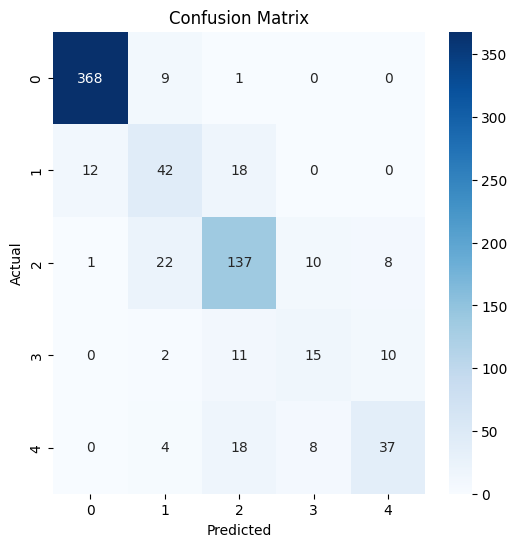

In [ ]:
print("Training EfficientNet...")
efficientnet_model = train_model(efficientnet_model, train_loader, val_loader, epochs=12)
evaluate_model(efficientnet_model, val_loader)

Validation Accuracy: 63.85%
Confusion Matrix:
 [[367   8   0   0   1]
 [  7  34   1   0  23]
 [  6  20  21   1 165]
 [  0   1   0   0  28]
 [  1   3   0   0  46]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       376
           1       0.52      0.52      0.52        65
           2       0.95      0.10      0.18       213
           3       0.00      0.00      0.00        29
           4       0.17      0.92      0.29        50

    accuracy                           0.64       733
   macro avg       0.52      0.50      0.39       733
weighted avg       0.83      0.64      0.62       733



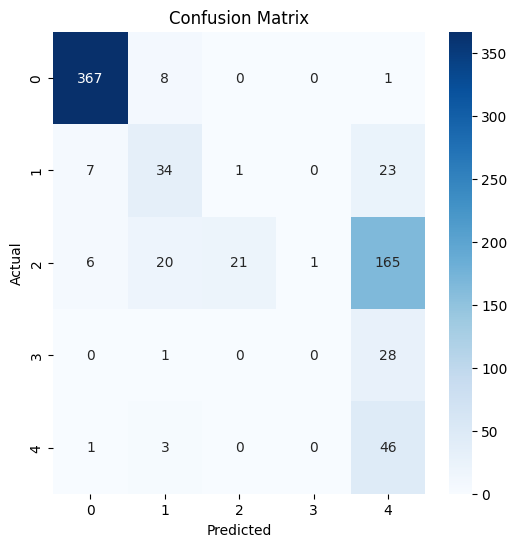

In [ ]:
evaluate_model(resnet_model, val_loader)